In [1]:
import numpy as np
#import matplotlib
#matplotlib.use('nbagg')
import os
from tqdm import tqdm
import fish_track as ft
import fish_corr as fc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from skvideo.io import vread
from scipy.spatial.distance import cdist, squareform, pdist
from scipy import ndimage
from scipy.optimize import curve_fit, least_squares
from scipy.spatial.transform import Rotation as R
import yaggie
import pickle

%load_ext autoreload
%autoreload 2

# Read Data

In [4]:
with open('vanilla_trajectories.pkl', 'rb') as f:
    trajectories = pickle.load(f)
blur = None

fish_trajs = []

for traj in trajectories:
    xyz = np.array(traj['position']).T
    #xyz = ndimage.gaussian_filter1d(xyz, 2, axis=1)
    t = np.array(traj['time'])
    ti = np.arange(t[0], t[-1]+1, 1)
    xi = np.interp(x = ti, xp = t, fp = xyz[0])
    yi = np.interp(x = ti, xp = t, fp = xyz[1])
    zi = np.interp(x = ti, xp = t, fp = xyz[2])
    xyz_int = np.vstack((xi, yi, zi))
    T = ft.FishTrajectory(t, xyz.T, blur)
    fish_trajs.append(T)
    
manager = ft.FishManager(fish_trajs)

print(manager)

trajectory manager: 116 trajectories


# Visualising Group Centres

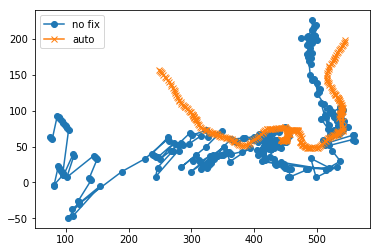

In [9]:
gce_1 = fc.utility.GCE(manager.trajs)
gce_3 = fc.utility.GCE(manager.trajs, 20)
plt.plot(*gce_1.centres.T[:2], '-o', label='no fix')
plt.plot(*gce_3.centres.T[:2], '-x', label='auto')
plt.legend()
plt.show()

# Ordered Movements

In [10]:
analyser = fc.order.Dynamical(manager.trajs, good_frames=20)
r_orders = analyser.get_rot_orders()
t_orders = analyser.get_trans_orders()
d_orders = analyser.get_dila_orders()

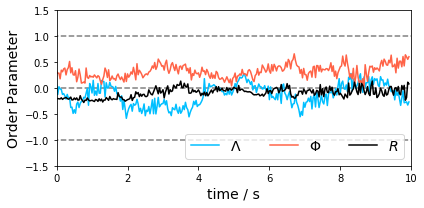

In [11]:
x = np.arange(-1, 11, 1)
y1 = np.ones(x.shape) * -1
y2 = np.ones(x.shape) * 0
y3 = np.ones(x.shape) * 1
plt.plot(x, y1, '--', color='k', alpha=0.5)
plt.plot(x, y2, '--', color='k', alpha=0.5)
plt.plot(x, y3, '--', color='k', alpha=0.5)
plt.plot(np.arange(299)/30, d_orders, label=r'$\Lambda$', color='deepskyblue')
plt.plot(np.arange(299)/30, np.abs(t_orders), label=r'$\Phi$', color='tomato')
plt.plot(np.arange(299)/30, r_orders, label=r'$R$', color='k')
plt.legend(fontsize=14, loc='lower right', ncol=3)
plt.ylim(-1.5, 1.5)
plt.xlim(0, 10)
plt.xlabel('time / s', fontsize=14)
plt.ylabel(f'Order Parameter', fontsize=14)
plt.gcf().set_size_inches(6, 3)
plt.tight_layout()
plt.savefig('order_par.pdf')
plt.show()

# Convex Hull of the group

Effective diameter is 175.91±18.33


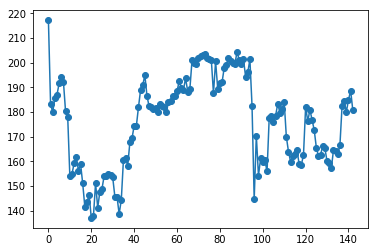

In [23]:
diameters = []
for ch in fc.utility.get_convex_hull(manager.trajs, 16):
    v = ch.volume
    d = (6*v/np.pi) ** (1/3)
    diameters.append(d)
plt.plot(diameters, '-o')
print(f"Effective diameter is {np.mean(diameters):.2f}±{np.std(diameters):.2f}")

# Radius of Gyration

Effective diameter is 98.45±16.28


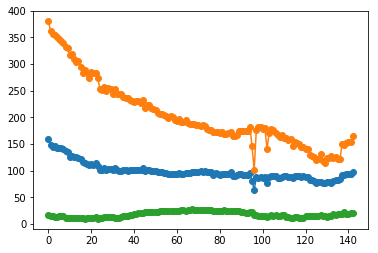

In [24]:
radii = []
r_max, r_min = [], []
for S in fc.utility.get_rg_tensor(manager.trajs, 16):
    eig = np.sqrt(np.linalg.eigvals(S))
    r_max.append(np.max(eig))
    r_min.append(np.min(eig))
    radii.append(np.mean(eig))
plt.plot(radii, '-o')
plt.plot(r_max, '-o')
plt.plot(r_min, '-o')
print(f"Effective diameter is {np.mean(radii):.2f}±{np.std(radii):.2f}")

# ACF of Order

/home/yushi/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


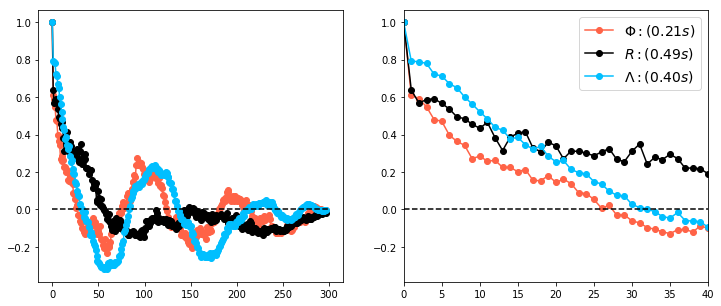

In [14]:
acf_trans = fc.utility.get_acf(t_orders)
acf_rot = fc.utility.get_acf(r_orders)
acf_dila = fc.utility.get_acf(d_orders)
    
length = 40
tao_trans = np.trapz(acf_trans[:length], np.arange(length)/30)
tao_rot = np.trapz(acf_rot[:length], np.arange(length)/30)
tao_dila = np.trapz(acf_dila[:length], np.arange(length)/30)

plt.subplot(121).plot(acf_trans, '-o', color='tomato', label=fr'$\Phi: ({tao_trans:.2f} s)$')
plt.subplot(121).plot(acf_rot, '-o', color='k', label=fr'$R: ({tao_rot:.2f} s)$')
plt.subplot(121).plot(acf_dila, '-o', color='deepskyblue', label=fr'$\Lambda: ({tao_dila:.2f} s)$')
plt.subplot(121).plot([0, 300], [0, 0], '--', color='k')

plt.subplot(122).plot(acf_trans, '-o', color='tomato', label=fr'$\Phi: ({tao_trans:.2f} s)$')
plt.subplot(122).plot(acf_rot, '-o', color='k', label=fr'$R: ({tao_rot:.2f} s)$')
plt.subplot(122).plot(acf_dila, '-o', color='deepskyblue', label=fr'$\Lambda: ({tao_dila:.2f} s)$')
plt.subplot(122).plot([0, 300], [0, 0], '--', color='k')
plt.gca().set_xlim(0, length)

plt.gcf().set_size_inches(12, 5)
plt.legend(fontsize=14)
plt.show()

# Velocity Correlations

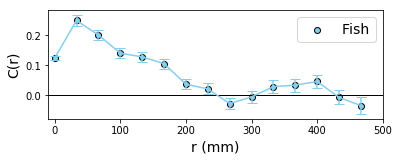

In [15]:
bins = np.linspace(0, 500, 16)
corr = fc.correlation.my_cvv(manager.trajs, bins, range(300), 20)

pixel_to_cm = 1/1
frame_to_s = 1/30

fish_sizes = np.array([np.count_nonzero(~np.isnan(c)) for c in corr])

plt.errorbar(bins[:-1] * pixel_to_cm, np.nanmean(corr, 1),
             np.nanstd(corr, 1) / np.sqrt(fish_sizes),
             color='skyblue', capsize=5)

plt.scatter(bins[:-1] * pixel_to_cm, np.nanmean(corr, 1),
            color='skyblue', edgecolor='k', label='Fish')

plt.plot([-10, 500], [0, 0], color='k', linewidth=1)
plt.xlim(-10, 500)
plt.ylabel('C(r)', fontsize=14)
plt.xlabel('r (mm)', fontsize=14)
plt.legend(fontsize=14, loc='upper right')
plt.gcf().set_size_inches(6, 2)
plt.savefig('cvv.pdf')
plt.show()

/home/yushi/Code/FishPy/fish_corr/correlation.py:158: RuntimeWarning: invalid value encountered in less
  index_1, index_2 = np.where(np.abs(dists - b - db/2) < db)


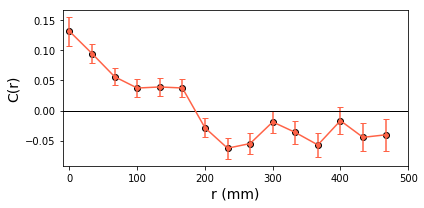

In [16]:
bins = np.linspace(0, 500, 16)
corr = fc.correlation.cavagna_cvv(manager.trajs, bins, range(300), 20)

frame_to_s = 1/30

fish_sizes = np.array([np.count_nonzero(~np.isnan(c)) for c in corr])

plt.scatter(bins[:-1], np.nanmean(corr, 1),
            color='tomato', edgecolor='k', label='Fish')

plt.errorbar(bins[:-1], np.nanmean(corr, 1),
             np.nanstd(corr, 1) / np.sqrt(fish_sizes),
             color='tomato', capsize=3)

plt.plot([-10, 500], [0, 0], color='k', linewidth=1)
plt.xlim(-10, 500)
plt.ylabel('C(r)', fontsize=14)
plt.xlabel('r (mm)', fontsize=14)
plt.gcf().set_size_inches(6, 3)
plt.tight_layout()
plt.show()